# Lab III

In [1]:
import torch
import plotly.express as px

## Exercice 1

In [2]:
# Exercice 1
X = torch.normal(0, 1, (60, 1))
w = torch.tensor([1.0])
eps = torch.normal(0, 0.1, (1, 60))
y = X @ w - 1 + eps

features = X
labels = y.reshape(-1, 1)

In [3]:
fig = px.scatter(x=features[:, 0], y=labels[:, 0])
fig.show()

In [4]:
from torch import nn

net = nn.Sequential(
    nn.Linear(3, 1)
)

In [5]:
net[0].weight.data.normal_(0, 1)
net[0].bias.data.fill_(1)
net[0]

Linear(in_features=3, out_features=1, bias=True)

## Exercise 2

In [6]:
import torchvision
from torchvision import transforms

In [10]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

def load_data_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    
    mnist_train = MNIST(root="../data", train=True, transform=trans, download=True)
    mnist_test = MNIST(root="../data", train=False, transform=trans, download=True)
    
    mnist_train, mnist_val = random_split(mnist_train, [50000, 10000], generator=torch.Generator().manual_seed(42))
    
    return (DataLoader(mnist_train, batch_size, shuffle=True, num_workers=2),
            DataLoader(mnist_val, batch_size, shuffle=False, num_workers=2),
            DataLoader(mnist_test, batch_size, shuffle=False, num_workers=2))

In [11]:
train_data, val_data, test_data = load_data_mnist(100)

In [12]:
net = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(784, 10)
)

In [13]:
loss = nn.CrossEntropyLoss()
lr = 0.15
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [14]:
def train(net, train_iter, val_iter, loss, num_epochs, optimizer):
    """Train a model."""
    
    def train_epoch(net, train_iter, loss, optimizer):  
        # Set the model to training mode
        net.train()
        # Sum of training loss, sum of training correct predictions, no. of examples
        total_loss = 0
        total_hits = 0
        total_samples = 0
        for X, y in train_iter:
            # Compute gradients and update parameters
            y_hat = net(X)
            l = loss(y_hat, y)
            # Using PyTorch built-in optimizer & loss criterion
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            total_loss += float(l)
            total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
        # Return training loss and training accuracy
        return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100
    
    def evaluate_accuracy(net, data_iter):
        """Compute the accuracy for a model on a dataset."""
        net.eval()  # Set the model to evaluation mode

        total_loss = 0
        total_hits = 0
        total_samples = 0
        with torch.no_grad():
            for X, y in data_iter:
                y_hat = net(X)
                l = loss(y_hat, y)
                total_loss += float(l)
                total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
                total_samples += y.numel()
        return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100
    
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

In [15]:
num_epochs = 15
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_data, val_data, loss, num_epochs, optimizer)

Epoch 1, Train loss 0.51, Train accuracy 87.09, Validation loss 0.37, Validation accuracy 89.50
Epoch 2, Train loss 0.35, Train accuracy 90.43, Validation loss 0.34, Validation accuracy 90.53
Epoch 3, Train loss 0.32, Train accuracy 91.01, Validation loss 0.33, Validation accuracy 90.74
Epoch 4, Train loss 0.31, Train accuracy 91.44, Validation loss 0.32, Validation accuracy 91.07
Epoch 5, Train loss 0.30, Train accuracy 91.72, Validation loss 0.31, Validation accuracy 91.26
Epoch 6, Train loss 0.29, Train accuracy 91.90, Validation loss 0.31, Validation accuracy 91.27
Epoch 7, Train loss 0.29, Train accuracy 92.09, Validation loss 0.30, Validation accuracy 91.42
Epoch 8, Train loss 0.28, Train accuracy 92.14, Validation loss 0.30, Validation accuracy 91.43
Epoch 9, Train loss 0.28, Train accuracy 92.31, Validation loss 0.30, Validation accuracy 91.44
Epoch 10, Train loss 0.28, Train accuracy 92.29, Validation loss 0.30, Validation accuracy 91.62
Epoch 11, Train loss 0.27, Train accura

In [16]:
import matplotlib.pyplot as plt

def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs') 
    plt.ylabel('Accuracy') 
    plt.legend()
    plt.show()


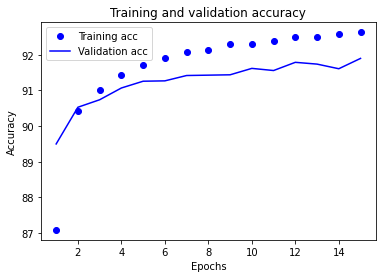

In [17]:
plot_accuracy(train_acc_all, val_acc_all)

In [19]:
def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

In [20]:
test_loss, test_acc = evaluate_accuracy(net, test_data)
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

Test loss 0.27, Test accuracy 92.40


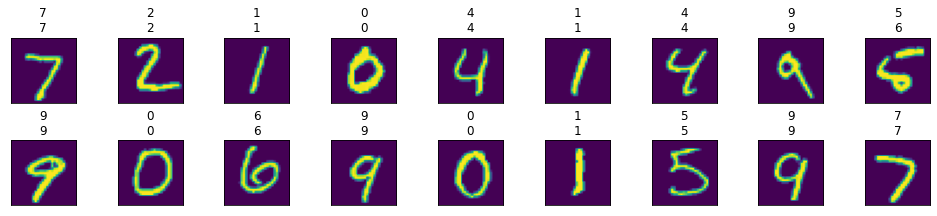

In [22]:
def data_labels(labels: list) -> list[str]:
    """Return text labels for the MNIST dataset."""
    text_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    plt.tight_layout()
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def predict(net, test_iter, n=18):
    """Predict labels."""
    for X, y in test_iter:
        break
    trues = data_labels(y)
    preds = data_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 2, int(n/2), titles=titles[0:n])

predict(net, test_data)